In [2]:
data_root = '/kaggle/input/child-mind-institute-detect-sleep-states'

#### Colab setup

In [4]:
colab = False

In [5]:
def download_data():
  !mkdir -p ~/.kaggle
  !wget -O ~/.kaggle/kaggle.json "https://drive.google.com/uc?export=download&id=1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0"
  !chmod 600 ~/.kaggle/kaggle.json

  !kaggle competitions download 'child-mind-institute-detect-sleep-states'
  !mkdir -p data
  !unzip -qqn child-mind-institute-detect-sleep-states.zip -d data

if colab:
  download_data()
  data_root = 'data'

--2023-11-27 14:15:33--  https://drive.google.com/uc?export=download&id=1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0
Resolving drive.google.com (drive.google.com)... 172.217.15.238, 2607:f8b0:4025:802::200e
Connecting to drive.google.com (drive.google.com)|172.217.15.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-80-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tcgcoqboem8di6q7g36febvtlhm3cjqe/1701094500000/12009704024140886017/*/1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0?e=download&uuid=e312b9e8-76c1-4e04-95a0-b1af3560767b [following]
--2023-11-27 14:15:34--  https://doc-14-80-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tcgcoqboem8di6q7g36febvtlhm3cjqe/1701094500000/12009704024140886017/*/1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0?e=download&uuid=e312b9e8-76c1-4e04-95a0-b1af3560767b
Resolving doc-14-80-docs.googleusercontent.com (doc-14-80-docs.googleusercontent.com)... 172.217.0.65, 2607:f8b0:4025:810

### Imports

- os: to handle file system paths
- gc: garbage collector to free up space mid-run
- pyarrow: parquet reading
- pandas: data analysis
- numpy: calculations

In [6]:
from os import path
import gc
import pyarrow as pa
import pyarrow.parquet
import pandas as pd
import numpy as np

data_root: the path to the directory containing the train and test data

### Importing the training events

train_events: contains the data from train_events.csv, this includes:
- **series_id (str)**: id of a series corresponding to a person's readings
- **night (int)**: nth night in a given series
- **event (str)**: either onset or wakeup
- **step (int)**: there is 1 reading in the train_series every 5 seconds, 1 step is this interval

series_list: all the unique series_ids in one list

In [7]:
train_events = pd.read_csv(
    path.join(data_root, 'train_events.csv'),
    dtype={
        'series_id': 'str',
        'night': 'Int32',
        'event': 'str',
        'step': 'Int64',
    }
)
series_list = train_events['series_id'].unique()
print(series_list[:10])
print(len(series_list))

['038441c925bb' '03d92c9f6f8a' '0402a003dae9' '04f547b8017d'
 '05e1944c3818' '062cae666e2a' '062dbd4c95e6' '08db4255286f'
 '0a96f4993bd7' '0cd1e3d0ed95']
277


### Preprocessing the training events

Drop events without time information. We do this because an **event without time information means there was no sleep recorded** for the given night.

In [8]:
train_events = train_events.dropna(axis=0)
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9585 entries, 0 to 14505
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   series_id  9585 non-null   object
 1   night      9585 non-null   Int32 
 2   event      9585 non-null   object
 3   step       9585 non-null   Int64 
 4   timestamp  9585 non-null   object
dtypes: Int32(1), Int64(1), object(3)
memory usage: 430.6+ KB


#### Filter out invalid nights

An invalid night is a night where either the **onset or wakeup time is missing**.

In [9]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights = bad_nights[bad_nights['event']!=2].reset_index()
print(bad_nights)

      series_id  night  event
0  0ce74d6d2106     20      1
1  154fe824ed87     30      1
2  44a41bba1ee7     10      1
3  efbfc4526d58      7      1
4  f8a8da8bdd00     17      1


In [10]:
bad_series = bad_nights['series_id'].unique()

In [11]:
print(bad_series)

['0ce74d6d2106' '154fe824ed87' '44a41bba1ee7' 'efbfc4526d58'
 'f8a8da8bdd00']


In [12]:
train_events = train_events[~(train_events['series_id'].isin(bad_series))]

In [13]:
series_list = train_events['series_id'].unique()
print(series_list[:10])
print(len(series_list))

['038441c925bb' '03d92c9f6f8a' '0402a003dae9' '04f547b8017d'
 '05e1944c3818' '062cae666e2a' '062dbd4c95e6' '08db4255286f'
 '0a96f4993bd7' '0cd1e3d0ed95']
264


### Importing the training time series

train_series: contains the data from train_series.parquet, this includes:
- **series_id (str)**: id of a series corresponding to a person's readings
- **anglez (float)**: z-angle is a metric that refers to the angle of the arm relative to the vertical axis of the body
- **enmo (float)**: Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero

not included:
- **step (int)**: there is 1 reading in the train_series every 5 seconds, 1 step is this interval
- **timestamp (timestamp)**: the time of the reading
we do not need time information as there is no causation between sleep state changes and time

In [14]:
train_series = pd.read_parquet(path.join(data_root, 'train_series.parquet'), columns=['series_id', 'anglez', 'enmo'])

### Standardization

Using the **StandardScaler** from sklearn.preprocessing we can easily standardize our dataset to have the properties:
- mean = 0
- std = 1

In [14]:
train_series.describe([])

anglez          enmo
count  1.279463e+08  1.279463e+08
mean  -8.810453e+00  4.131503e-02
std    3.552188e+01  1.018289e-01
min   -9.000000e+01  0.000000e+00
50%   -9.597900e+00  1.720000e-02
max    9.000000e+01  1.143370e+01

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
input_scaler = scaler.fit(train_series[['anglez', 'enmo']])
train_series[['anglez', 'enmo']] = scaler.transform(train_series[['anglez', 'enmo']])

In [16]:
train_series.describe([])

anglez          enmo
count  1.279463e+08  1.279463e+08
mean   1.132486e-08 -1.056816e-08
std    1.000000e+00  1.000000e+00
min   -2.285620e+00 -4.057302e-01
50%   -2.216730e-02 -2.368194e-01
max    2.781680e+00  1.118777e+02

In [17]:
event_map = {}
for series_id, events in train_events.groupby('series_id'):
    event_map[series_id] = events.drop(columns=['series_id', 'timestamp']).reset_index(drop=True)

In [18]:
series_map = {}
for series_id, series in train_series.groupby('series_id'):
    series_map[series_id] = series[['enmo', 'anglez']].to_numpy()

### Splitting training and test series

In [19]:
test_series_ids = set(series_list[0:2])
train_series_ids = set(series_list[2:])

In [20]:
train_series = None
gc.collect()

0

### Sampling data

In [21]:
import random
import matplotlib.pyplot as plt

In [22]:
FRAME_SIZE = 60 * 12 # frame width
MIN_NONE_SAMPLE_INTERVAL = 4 * 60 * 12 # minimum steps between events to sample none frames from
NONE_PADDING = 30 * 12 # padding between events and none frames
EVENT_SAMPLE_MARGIN = 15 * 12 # event margin to frame edges
EVENT_SAMPLE_STRIDE = 3 * 12 # event sampling stride

In [23]:
# Extracts samples between two events
def sample_between(start, end, n_samples, padding=NONE_PADDING) -> list[tuple[int]]:
    samples = []
    gap = (end - start - 2 * padding - n_samples * FRAME_SIZE) // (n_samples - 1)
    stride = gap + FRAME_SIZE
    for frame_start in range(start + padding, end - FRAME_SIZE - padding + 1, stride):
        samples.append((frame_start, frame_start+FRAME_SIZE))
    return samples

In [24]:
# Extracts samples around an event
def sample_around(event, margin, stride) -> list[list]:
    samples = []
    for frame_start in range(event - FRAME_SIZE + margin + 1, event - margin + 1, stride):
        samples.append((frame_start, frame_start + FRAME_SIZE))
    return samples

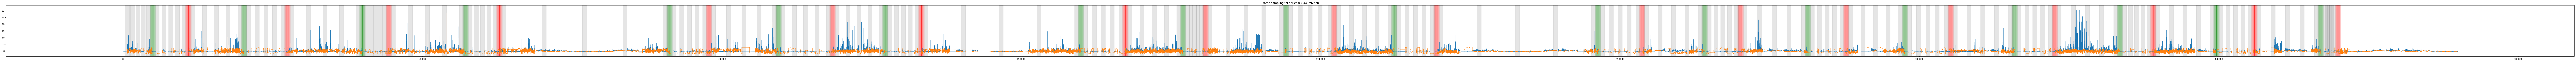

In [25]:
def display_sampling(series_id):
    series = series_map[series_id]
    events = event_map[series_id]
    plt.figure(figsize=(200, 4))
    plt.title(f'Frame sampling for series {series_id}')

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_color = 'green' if type == 'onset' else 'red'
        plt.axvline(step, color=event_color, lw=0.5)

        event_samples = sample_around(step, EVENT_SAMPLE_MARGIN, EVENT_SAMPLE_STRIDE)
        for frame_start, frame_end in event_samples:
            plt.axvspan(frame_start, frame_end, color=event_color, alpha=0.05)

        if step - last_event_step >= MIN_NONE_SAMPLE_INTERVAL:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                plt.axvspan(frame_start, frame_end, color='black', alpha=0.1)
        last_event_step = step
    plt.plot(series, lw=0.5)

display_sampling(series_list[0])

In [26]:
X_none = []
X_onset = []
X_onset_time = []
X_wakeup = []
X_wakeup_time = []
for series_id in train_series_ids:
    series = series_map[series_id]
    events = event_map[series_id]

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_samples = sample_around(step, EVENT_SAMPLE_MARGIN, EVENT_SAMPLE_STRIDE)
        for frame_start, frame_end in event_samples:
            if frame_start < 0 or frame_end >= series.shape[0]:
                continue
            if type == 'onset':
                X_onset.append(series[frame_start:frame_end])
                X_onset_time.append(step - frame_start)
            if type == 'wakeup':
                X_wakeup.append(series[frame_start:frame_end])
                X_wakeup_time.append(step - frame_start)
        if step - last_event_step >= MIN_NONE_SAMPLE_INTERVAL:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                X_none.append(series[frame_start:frame_end])
        last_event_step = step

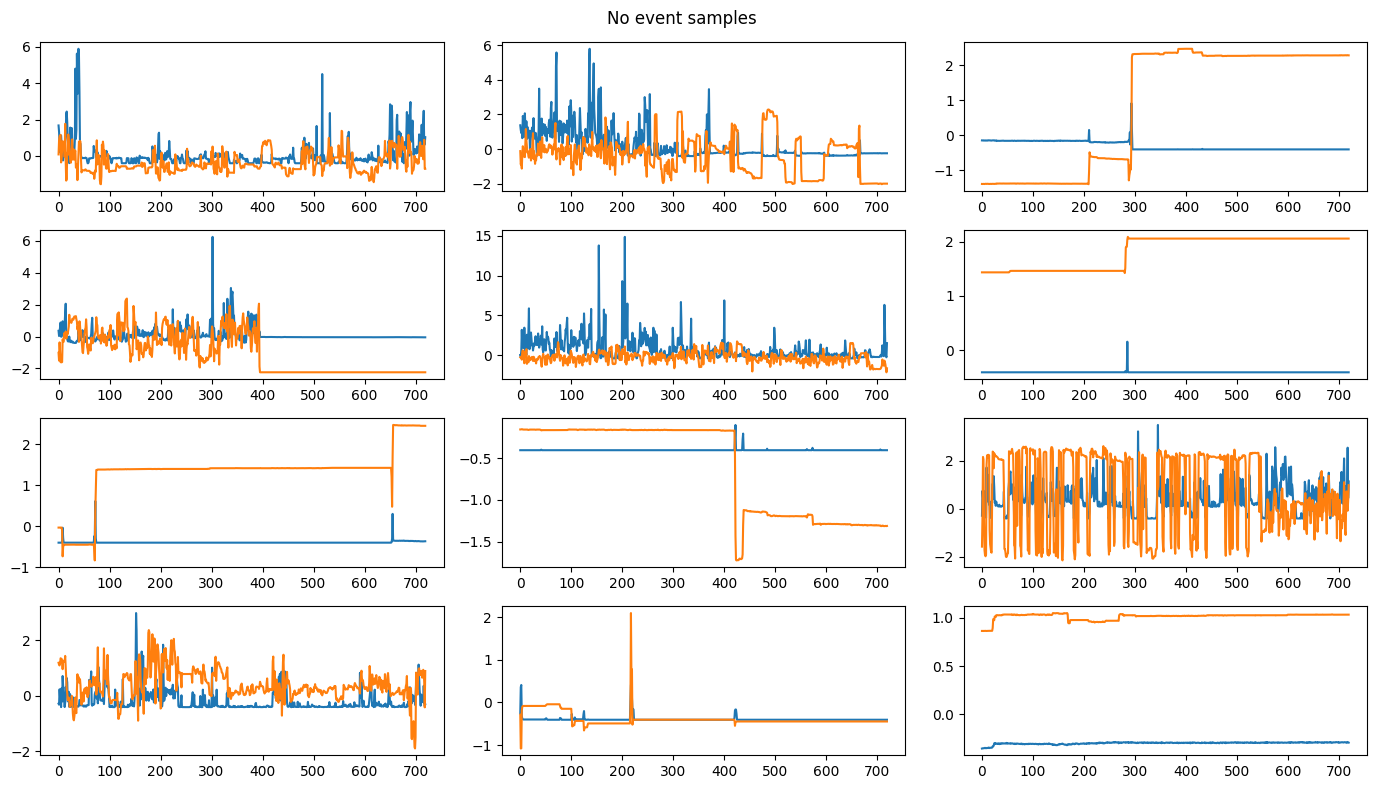

In [27]:
def plot_none_samples(samples):
    cols = 3
    rows = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].plot(samples[j * rows + i])
    plt.suptitle('No event samples')
    plt.tight_layout()
    plt.show()

plot_none_samples(random.sample(X_none, 12))

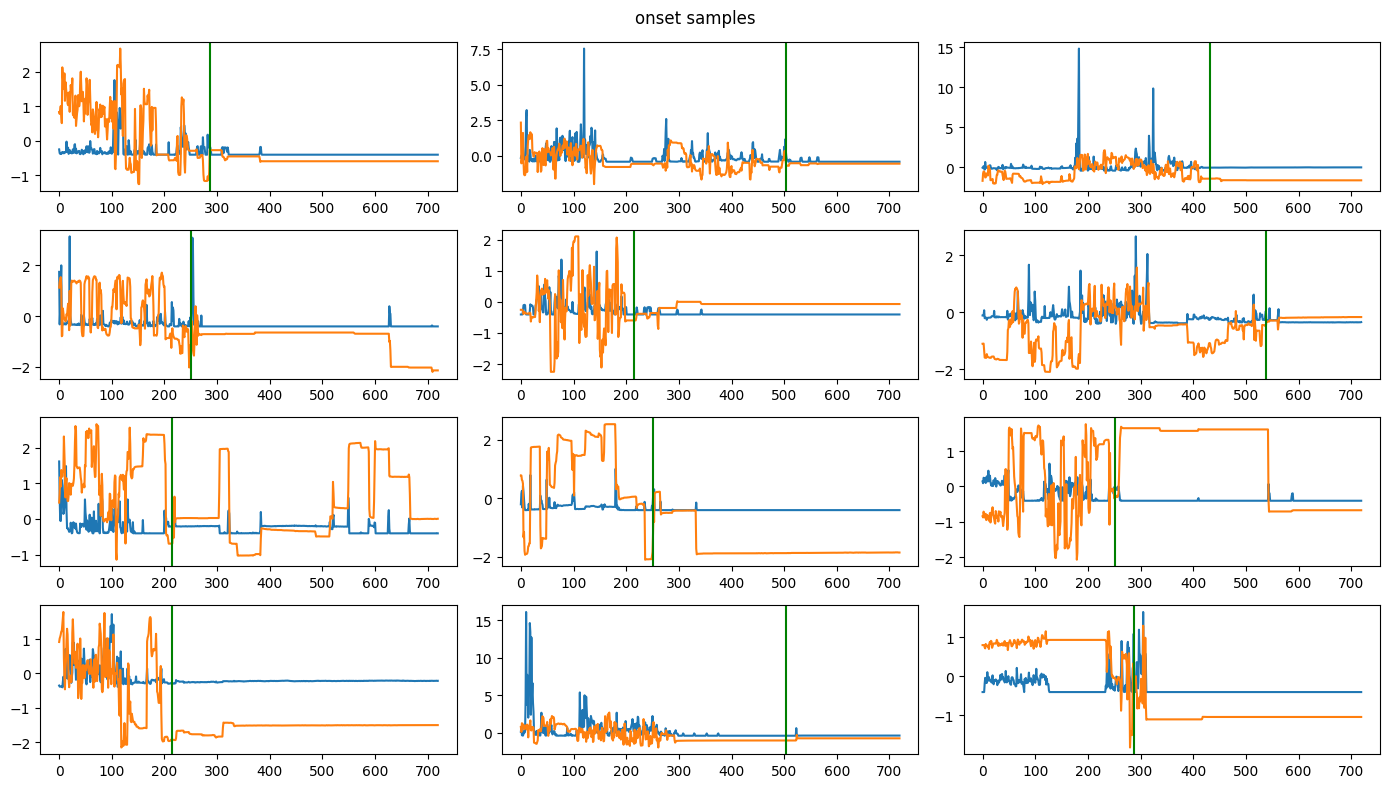

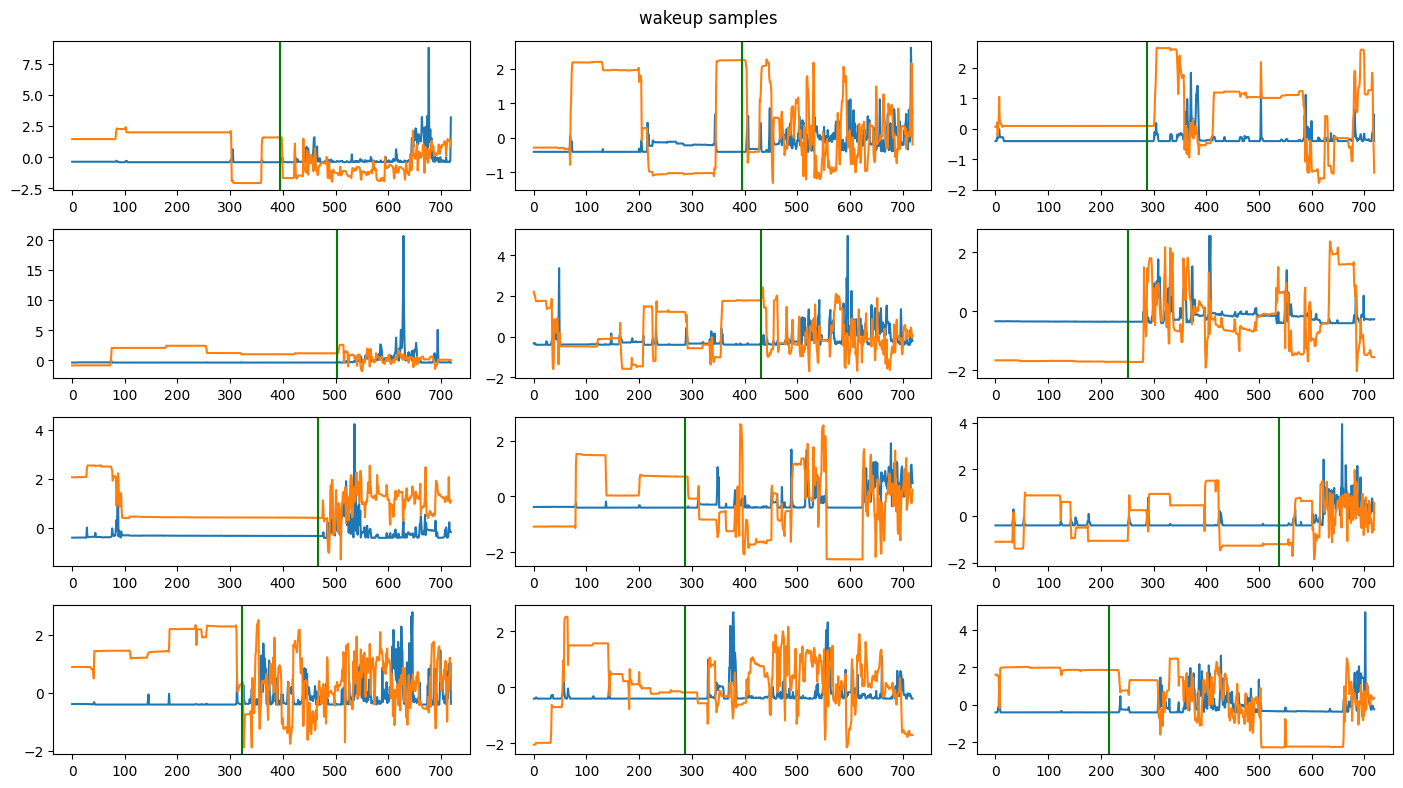

In [28]:
def plot_event_samples(type, samples: list[tuple]):
    cols = 3
    rows = 4
    _, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            sample = samples[j * rows + i]
            ax[i][j].plot(sample[0])
            ax[i][j].axvline(sample[1], c='green')
    plt.suptitle(f'{type} samples')
    plt.tight_layout()
    plt.show()

plot_event_samples('onset', random.sample(list(zip(X_onset, X_onset_time)), 12))
plot_event_samples('wakeup', random.sample(list(zip(X_wakeup, X_wakeup_time)), 12))

### Assembling the dataset

In [29]:
n_samples = len(X_none) + len(X_onset) + len(X_wakeup)
n_features = 2

X = np.empty([n_samples, FRAME_SIZE, n_features], dtype=np.float32) # input
Y = np.zeros([n_samples, 3], dtype=np.float32) # labels

idx = 0
def fill_data(x, y_idx):
    global idx
    n = len(x)
    X[idx:idx + n] = x
    Y[idx:idx + n, y_idx] = 1.0
    idx += n

fill_data(X_none, 0)
fill_data(X_onset, 1)
fill_data(X_wakeup, 2)

In [30]:
print(X.shape)
print(Y.shape)

(139437, 720, 2)
(139437, 3)


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))

118521 118521
20916 20916


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model
model = Sequential()
model.add(Conv1D(128, 4, activation='relu', input_shape=(FRAME_SIZE, n_features)))
model.add(MaxPooling1D(4))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint("model.hdf5", save_best_only=True)
network_history = model.fit(X_train, Y_train, epochs=5, validation_split=0.15, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint])

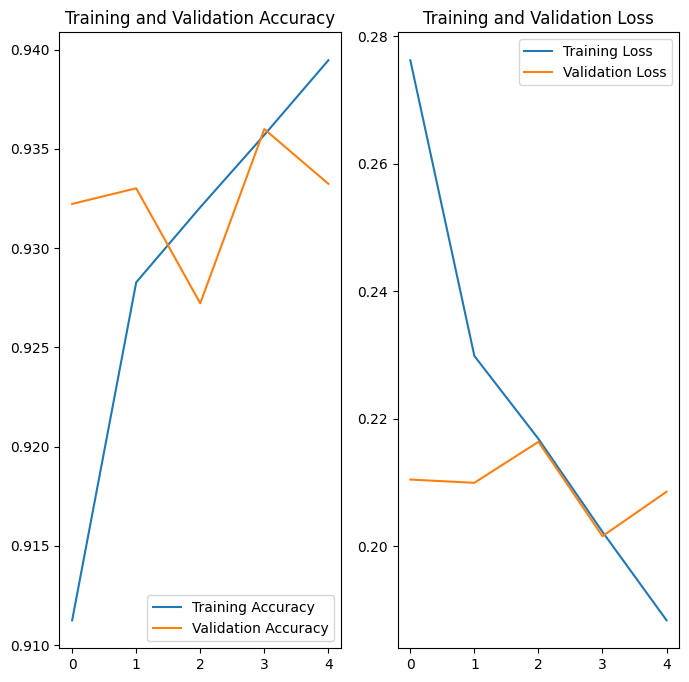

In [36]:
acc = network_history.history['accuracy']
val_acc = network_history.history['val_accuracy']

loss = network_history.history['loss']
val_loss = network_history.history['val_loss']

epochs_range = range(len(network_history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
from keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(X_test,Y_test)
print(f"Test loss: {test_err[0]:.2}, Test accuracy: {test_err[1]:.2%}")

output = ['none', 'onset', 'wakeup']
print(output[np.argmax(model.predict(X[1].reshape(1, -1 , 2)))])
print(output[np.argmax(model.predict(X[len(X)//2].reshape(1, -1 , 2)))])
print(output[np.argmax(model.predict(X[-1].reshape(1, -1 , 2)))])

654/654 [==============================] - 15s 22ms/step - loss: 0.1941 - accuracy: 0.9356
Test loss: 0.19, Test accuracy: 93.56%
1/1 [==============================] - 0s 95ms/step
none
1/1 [==============================] - 0s 29ms/step
onset
1/1 [==============================] - 0s 24ms/step
wakeup


### Prediction

In [224]:
PRED_STRIDE = 5 * 12
PRED_PROBABILITY_THRESHOLD = 0.95
PRED_MERGE_THRESHOLD = 20 * 12

In [225]:
EVT_ONSET = 1
EVT_WAKEUP = 2

In [226]:
test_series = series_map[series_list[0]]


In [227]:
test_events = event_map[series_list[0]]

sleeps_actual = [tuple(events['step']) for night, events in test_events.groupby('night')]

onsets_actual = test_events[test_events['event'] == 'onset']['step'].to_numpy(dtype=np.int32)
wakeups_actual = test_events[test_events['event'] == 'wakeup']['step'].to_numpy(dtype=np.int32)

In [228]:
def get_rolling_frames(series):
    n_frames = (series.shape[0] - FRAME_SIZE) // PRED_STRIDE + 1
    centers = np.empty([n_frames])
    frames = np.empty([n_frames, FRAME_SIZE, n_features])
    for idx, frame_start in enumerate(range(0, series.shape[0] - FRAME_SIZE + 1, PRED_STRIDE)):
        frames[idx] = series[frame_start:frame_start + FRAME_SIZE]
        centers[idx] = frame_start + FRAME_SIZE // 2
    return frames, centers

In [229]:
def get_predicted_events(predictions, frame_centers, event_idx):
    predicted_events = []
    for idx, pred in enumerate(predictions):
        p = pred[event_idx] # predicted probability of event
        if p >= PRED_PROBABILITY_THRESHOLD:
            predicted_events.append(frame_centers[idx])
    return predicted_events

In [230]:
prediction_frames, centers = get_rolling_frames(test_series)
#print(prediction_frames)
predictions = model.predict(prediction_frames)

onsets_predicted = get_predicted_events(predictions, centers, EVT_ONSET)
wakeups_predicted = get_predicted_events(predictions, centers, EVT_WAKEUP)

203/203 [==============================] - 5s 25ms/step


In [231]:
def plot_events(series, onset_events, wakeup_events):
    plt.figure(figsize=(200, 4))
    plt.xticks(range(0,series.shape[0], 8640))
    for step in onset_events:
        plt.axvline(step, color='green')
    for step in wakeup_events:
        plt.axvline(step, color='red')
    plt.plot(series, lw=0.5)

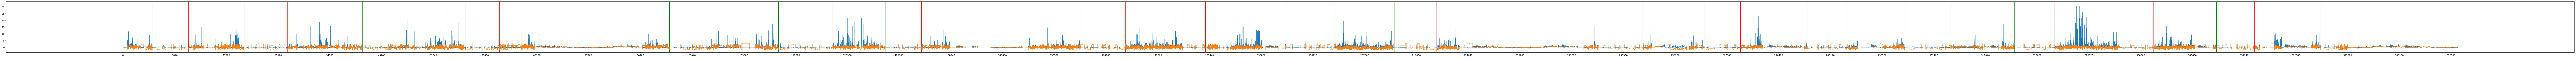

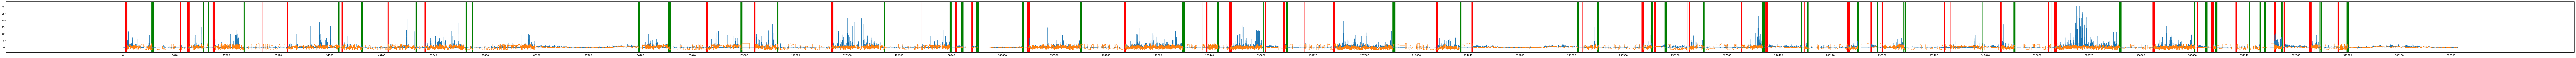

In [232]:
plot_events(test_series, onsets_actual, wakeups_actual)
plot_events(test_series, onsets_predicted, wakeups_predicted)

In [233]:
def combine_predictions(predictions):
    combined = []
    segment = []
    last = None
    for step in predictions:
        if last != None and step - last > PRED_MERGE_THRESHOLD:
            points = np.array(segment)
            combined.append(points.mean())
            segment.clear()
        segment.append(step)
        last = step
    return combined

In [234]:
onsets_prediced = combine_predictions(onsets_predicted)
wakeups_predicted = combine_predictions(wakeups_predicted)

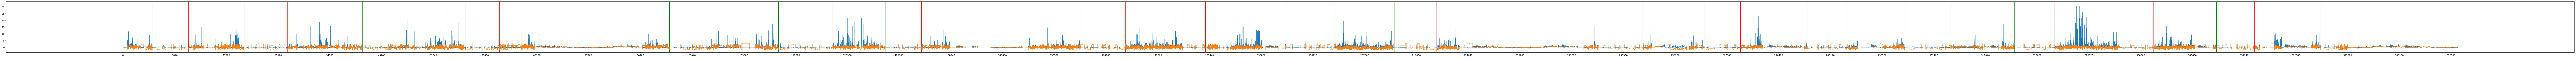

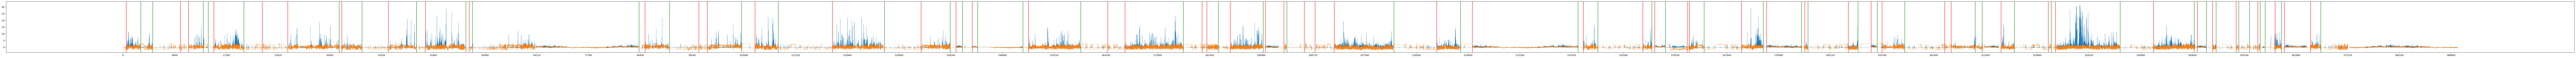

In [235]:
plot_events(test_series, onsets_actual, wakeups_actual)
plot_events(test_series, onsets_prediced, wakeups_predicted)

In [236]:
def merge_events(onsets, wakeups):
    merged_events = []
    merged_events.extend([(EVT_ONSET, step) for step in onsets])
    merged_events.extend([(EVT_WAKEUP, step) for step in wakeups])
    merged_events.sort(key=lambda event: event[1])
    return merged_events

In [237]:
def fit_sleep_periods(events):
    sleeps = []

    sleep_start = None
    sleep_end = None

    for event, step in events:
        if event == EVT_WAKEUP and sleep_start == None:
            continue
        if event == EVT_ONSET and sleep_start == None:
            sleep_start = step
        if event == EVT_WAKEUP and sleep_start != None:
            sleep_end = step
        if event == EVT_ONSET and sleep_end != None:
            sleeps.append((sleep_start, sleep_end))
            sleep_start = step
            sleep_end = None

    return sleeps

In [238]:
sleeps_predicted = fit_sleep_periods(merge_events(onsets_predicted, wakeups_predicted))

In [242]:
def plot_sleep_periods(series, sleeps):
    plt.figure(figsize=(200, 4))
    plt.xticks(range(0,series.shape[0], 8640))
    for sleep in sleeps:
        plt.axvspan(sleep[0], sleep[1], color='green', alpha=0.3)
    plt.plot(series, lw=0.5)
    pass

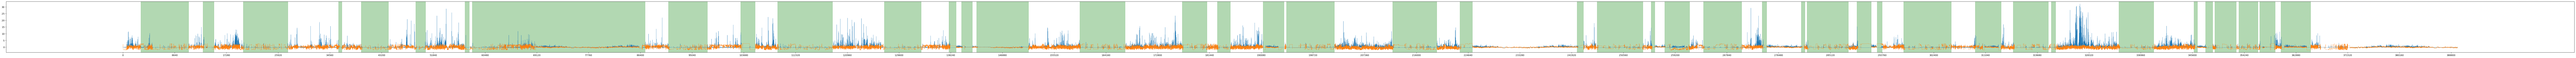

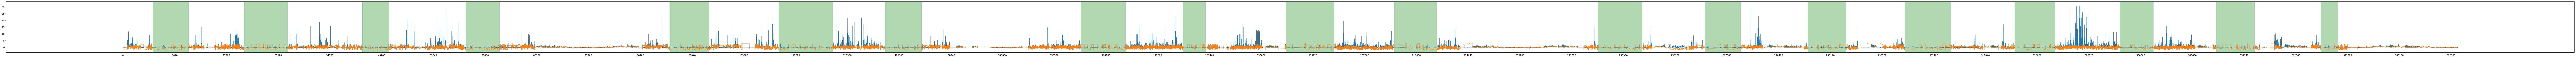

In [243]:
plot_sleep_periods(test_series, sleeps_predicted)
plot_sleep_periods(test_series, sleeps_actual)

In [285]:
def assign_to_nights(series_len, delta, sleep_periods):
    n_nights = (series_len - delta) // (24 * 60 * 12) + 1
    sleeps_per_night = [[] for _ in range(0, n_nights)]
    for start, end in sleep_periods:
        mid = int((start + end) / 2)
        night_idx = (mid - delta) // (24 * 60 * 12) + 1
        sleeps_per_night[night_idx].append((start, end))
    return sleeps_per_night

In [289]:
sleeps_separated = assign_to_nights(len(test_series), 6120 + 3 * 60 * 12, sleeps_predicted)

In [323]:
def filter_max(sleeps_nights):
    return [ max(sleeps, key=lambda sleep: sleep[1] - sleep[0]) for sleeps in sleeps_nights if sleeps != []]

In [324]:
filtered_sleeps = filter_max(sleeps_separated)

print(filtered_sleeps)

[(3000.0, 10950.0), (20100.0, 27540.0), (39780.0, 44340.0), (48900.0, 50520.0), (58320.0, 87180.0), (91080.0, 97580.0), (103140.0, 105570.0), (109320.0, 118470.0), (127140.0, 133290.0), (142560.0, 151200.0), (176880.0, 181020.0), (194280.0, 202290.0), (212040.0, 219390.0), (246180.0, 253800.0), (263940.0, 270300.0), (281220.0, 288120.0), (297360.0, 305310.0), (315660.0, 321510.0), (333300.0, 339120.0), (349320.0, 352890.0), (360360.0, 365310.0)]


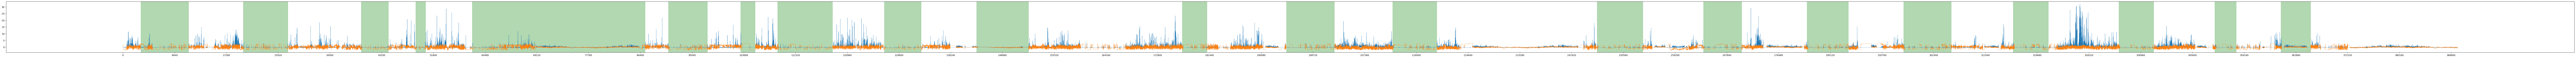

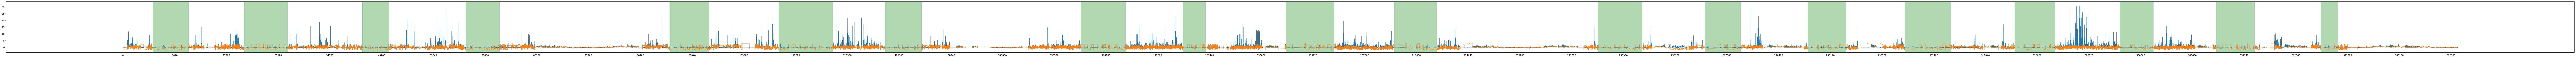

In [325]:
plot_sleep_periods(test_series, filtered_sleeps)
plot_sleep_periods(test_series, sleeps_actual)

In [327]:
submission = pd.DataFrame(columns=['series_id', 'step', 'event', 'score'])

print(submission)

for onset, wakeup in filtered_sleeps:
    sleep_df = pd.DataFrame([
        {'series_id': series_list[0], 'step': onset, 'event': 'onset', 'score': 0.5},
        {'series_id': series_list[0], 'step': wakeup, 'event': 'wakeup', 'score': 0.5}
    ])
    submission = pd.concat([submission, sleep_df], ignore_index=True)

display(submission)

Empty DataFrame
Columns: [series_id, step, event, score]
Index: []


series_id      step   event  score
0   038441c925bb    3000.0   onset    0.5
1   038441c925bb   10950.0  wakeup    0.5
2   038441c925bb   20100.0   onset    0.5
3   038441c925bb   27540.0  wakeup    0.5
4   038441c925bb   39780.0   onset    0.5
5   038441c925bb   44340.0  wakeup    0.5
6   038441c925bb   48900.0   onset    0.5
7   038441c925bb   50520.0  wakeup    0.5
8   038441c925bb   58320.0   onset    0.5
9   038441c925bb   87180.0  wakeup    0.5
10  038441c925bb   91080.0   onset    0.5
11  038441c925bb   97580.0  wakeup    0.5
12  038441c925bb  103140.0   onset    0.5
13  038441c925bb  105570.0  wakeup    0.5
14  038441c925bb  109320.0   onset    0.5
15  038441c925bb  118470.0  wakeup    0.5
16  038441c925bb  127140.0   onset    0.5
17  038441c925bb  133290.0  wakeup    0.5
18  038441c925bb  142560.0   onset    0.5
19  038441c925bb  151200.0  wakeup    0.5
20  038441c925bb  176880.0   onset    0.5
21  038441c925bb  181020.0  wakeup    0.5
22  038441c925bb  194280.0   onset    0.5
23  038441c925bb  202290.0  wakeup    0.5
24  038441c925bb  212040.0   onset    0.5
25  038441c925bb  219390.0  wakeup    0.5
26  038441c925bb  246180.0   onset    0.5
27  038441c925bb  253800.0  wakeup    0.5
28  038441c925bb  263940.0   onset    0.5
29  038441c925bb  270300.0  wakeup    0.5
30  038441c925bb  281220.0   onset    0.5
31  038441c925bb  288120.0  wakeup    0.5
32  038441c925bb  297360.0   onset    0.5
33  038441c925bb  305310.0  wakeup    0.5
34  038441c925bb  315660.0   onset    0.5
35  038441c925bb  321510.0  wakeup    0.5
36  038441c925bb  333300.0   onset    0.5
37  038441c925bb  339120.0  wakeup    0.5
38  038441c925bb  349320.0   onset    0.5
39  038441c925bb  352890.0  wakeup    0.5
40  038441c925bb  360360.0   onset    0.5
41  038441c925bb  365310.0  wakeup    0.5

In [ ]:
import pandas.api.types
from typing import Dict, List, Tuple


class ParticipantVisibleError(Exception):
    pass


# Set some placeholders for global parameters
series_id_column_name = None
time_column_name = None
event_column_name = None
score_column_name = None
use_scoring_intervals = None
def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
        series_id_column_name: str,
        time_column_name: str,
        event_column_name: str,
        score_column_name: str,
        use_scoring_intervals: bool = False,
) -> float:
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference({'start', 'end'}),\
        (f"Solution column {event_column_name} must contain the same events "
         "as defined in tolerances.")
    assert pd.api.types.is_numeric_dtype(solution[time_column_name]),\
        f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(f"Submission must have column '{target_name}'.")

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments
    globals()['series_id_column_name'] = series_id_column_name
    globals()['time_column_name'] = time_column_name
    globals()['event_column_name'] = event_column_name
    globals()['score_column_name'] = score_column_name
    globals()['use_scoring_intervals'] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)


def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x series_id evaluation group."""
    detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
            if error < best_error and gt not in gts_matched:
                best_gt = gt
                best_error = error

        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
) -> float:

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        intervals = (
            solution
            .query("event in ['start', 'end']")
            .assign(interval=lambda x: x.groupby([series_id_column_name, event_column_name]).cumcount())
            .pivot(
                index='interval',
                columns=[series_id_column_name, event_column_name],
                values=time_column_name,
            )
            .stack(series_id_column_name)
            .swaplevel()
            .sort_index()
            .loc[:, ['start', 'end']]
            .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
        )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        detections_filtered = []
        for (det_group, dets), (int_group, ints) in zip(
            detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
        ):
            assert det_group == int_group
            detections_filtered.append(filter_detections(dets, ints))
        detections_filtered = pd.concat(detections_filtered, ignore_index=True)
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths[series_id_column_name].unique()],
        columns=[event_column_name, 'tolerance', series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby([event_column_name, 'tolerance']).apply(
            lambda group: average_precision_score(
                group['matched'].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
    )
    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

    return mean_ap

In [ ]:
tolerances = {"onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
             "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
test_events['series_id'] = series_list[0]
print(score(test_events, submission.query('series_id == @series_list[0]'), tolerances, "series_id", "step", "event", "score"))